In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import xarray as xr

from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = get_latest_tuid(contains="Single-shot")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 198kB
Dimensions:  (dim_0: 2744)
Coordinates:
    x0       (dim_0) float64 22kB 4.8e-08 8.4e-08 1.16e-07 ... 4.64e-07 4.96e-07
    x1       (dim_0) float64 22kB 7.37e+09 7.37e+09 ... 7.42e+09 7.42e+09
    x2       (dim_0) float64 22kB 0.005 0.005 0.005 0.005 ... 0.07 0.07 0.07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 22kB 0.5121 0.5113 0.5073 ... 0.6654 0.6754 0.6877
    y1       (dim_0) float64 22kB 0.5138 0.5134 0.5043 ... 0.691 0.7051 0.7134
    y2       (dim_0) float64 22kB 0.5136 0.5111 0.5088 ... 0.742 0.7585 0.7749
    y3       (dim_0) float64 22kB 0.509 0.5095 0.5088 ... 0.5631 0.5624 0.5748
    y4       (dim_0) float64 22kB 0.5 0.5044 0.5 0.5 ... 0.5884 0.6033 0.6135
    y5       (dim_0) float64 22kB 0.5 0.5001 0.5 0.5 ... 0.5572 0.5739 0.5796
Attributes:
    tuid:                             20241127-010313-461-3332cc
    name:                             Single-shot readout vs. pulse duration,...
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

[[0.51214571 0.50772763 0.51114493 ... 0.56171143 0.53129891 0.52300806]
 [0.51134529 0.51394825 0.52481995 ... 0.59257097 0.55995771 0.53641114]
 [0.50731575 0.51241171 0.53670736 ... 0.61313522 0.58406329 0.5436983 ]
 ...
 [0.51999162 0.53331698 0.60116202 ... 0.70335544 0.76704032 0.66538047]
 [0.52036355 0.53475062 0.60807349 ... 0.70866914 0.78452422 0.67535119]
 [0.51358857 0.54161479 0.61479    ... 0.72321912 0.79303079 0.6877004 ]]
[[0.5        0.50879193 0.5        ... 0.5        0.5        0.5       ]
 [0.5000549  0.50231623 0.5        ... 0.51442097 0.5        0.5       ]
 [0.5        0.50017794 0.50218711 ... 0.51104043 0.51325377 0.50508041]
 ...
 [0.5        0.50622379 0.5        ... 0.53892556 0.69348635 0.55723627]
 [0.50063591 0.5        0.50295915 ... 0.53906994 0.72681795 0.5738949 ]
 [0.5        0.50713317 0.50269005 ... 0.56657552 0.73292953 0.57960441]]


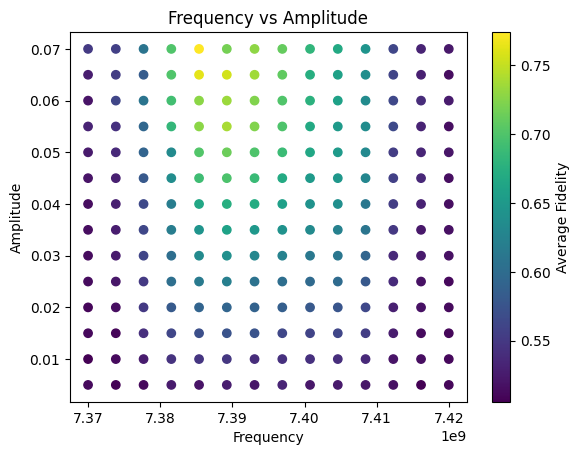

In [4]:
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data

QND_pi_fidelity = dataset.y5.data

freq_reshape_list = []
amplitude_reshape_list = []
average_fidelity_reshape_list = []
QND_pi_fidelity_reshape_list = []

# Count occurrences
unique_duration_values, counts = np.unique(duration, return_counts=True)

for i in unique_duration_values:
    indices = np.where(duration == i)
    freq_reshape_list.append(frequency[indices])
    amplitude_reshape_list.append(amplitude[indices])
    average_fidelity_reshape_list.append(average_fidelity[indices])
    QND_pi_fidelity_reshape_list.append(QND_pi_fidelity[indices])
    
freq_reshape = np.array(freq_reshape_list)
amplitude_reshape = np.array(amplitude_reshape_list)
average_fidelity_reshape = np.array(average_fidelity_reshape_list)
QND_pi_fidelity_reshape = np.array(QND_pi_fidelity_reshape_list)

print(average_fidelity_reshape)
print(QND_pi_fidelity_reshape)

plt.scatter(freq_reshape[0], amplitude_reshape[0], c=average_fidelity_reshape[0], cmap='viridis')
plt.colorbar(label='Average Fidelity')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Frequency vs Amplitude')
plt.show()

In [5]:
def plotFidelity(frequency: list, amplitude: list, fidelity: list, duration: list, title: str) -> None:
    n_subplots = len(duration)  # Number of subplots
    n_cols = 3  # Fixed 3 subplots per row
    n_rows = int(np.ceil(n_subplots / n_cols))  # Dynamically determine number of rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 22),dpi = 300)  # Increased figure size
    fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)  # Adjust spacing
    fig.suptitle(title, fontsize=20, x = 0.49, y=0.96)  # Set the overall title closer to subplots

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Create a colormap handle for the shared colorbar
    cmap = 'viridis'
    vmin = 0.5  # Minimum value across all fidelities
    vmax = 1  # Maximum value across all fidelities

    im = None  # Placeholder for the imshow object

    for i in range(n_subplots):
        ax = axes[i]
        
        x = frequency[i]
        y = amplitude[i]
        z = fidelity[i]

        Z = z.reshape(len(duration), len(duration))

        dx = (x.max() - x.min()) / (Z.shape[1] - 1)  # Step size along x-axis
        dy = (y.max() - y.min()) / (Z.shape[0] - 1)  # Step size along y-axis

        extent = [
            x.min() - 0.5 * dx, x.max() + 0.5 * dx,  # x-axis range
            y.min() - 0.5 * dy, y.max() + 0.5 * dy   # y-axis range
        ]

        im = ax.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f"Duration: {duration[i]:.3g} s", fontsize=12)
        ax.set_xlabel("Frequency [Hz]", fontsize=10)
        ax.set_ylabel("Amplitude [V]", fontsize=10)

        # Add a colorbar for this subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
        # cbar.set_label("Fidelity", fontsize=14)
    
    # Hide any unused subplots
    for j in range(n_subplots, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the overall title
    filename = "ssro duration frequency amplitude " + title + ".pdf"
    filename = filename.replace(" ", "_").lower()
    print(filename)
    plt.savefig(filename)
    plt.show()

# plotFidelity(freq_reshape, amplitude_reshape, average_fidelity_reshape, unique_duration_values, "Average fidelity")


In [6]:
# plotFidelity(freq_reshape, amplitude_reshape, QND_pi_fidelity_reshape, unique_duration_values, "QND pi fidelity")

In [7]:
def plotSingleFidelity(frequency: np.ndarray, amplitude: np.ndarray, fidelity: np.ndarray, title: str) -> None:
    """
    Plot a single heatmap using imshow for frequency, amplitude, and fidelity.
    """
    # Reshape fidelity to 2D (if not already a grid)
    Z = fidelity.reshape(len(np.unique(amplitude)), len(np.unique(frequency)))

    # Calculate the extent of the axes for imshow
    dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along x-axis
    dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along y-axis

    extent = [
        frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
        amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
    ]

    # Plot with imshow
    plt.figure(figsize=(10, 8), dpi=300)
    cmap = 'viridis'
    vmin, vmax = 0.5, 1  # Set fidelity range for consistent scaling

    im = plt.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Fidelity")
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency [Hz]", fontsize=12)
    plt.ylabel("Amplitude [V]", fontsize=12)
    # filename = title.replace(" ", "_").lower() + ".pdf"
    # print("Saving plot as:", filename)
    # plt.savefig(filename)
    plt.show()




Average Fidelity; Duration:4.96e-07


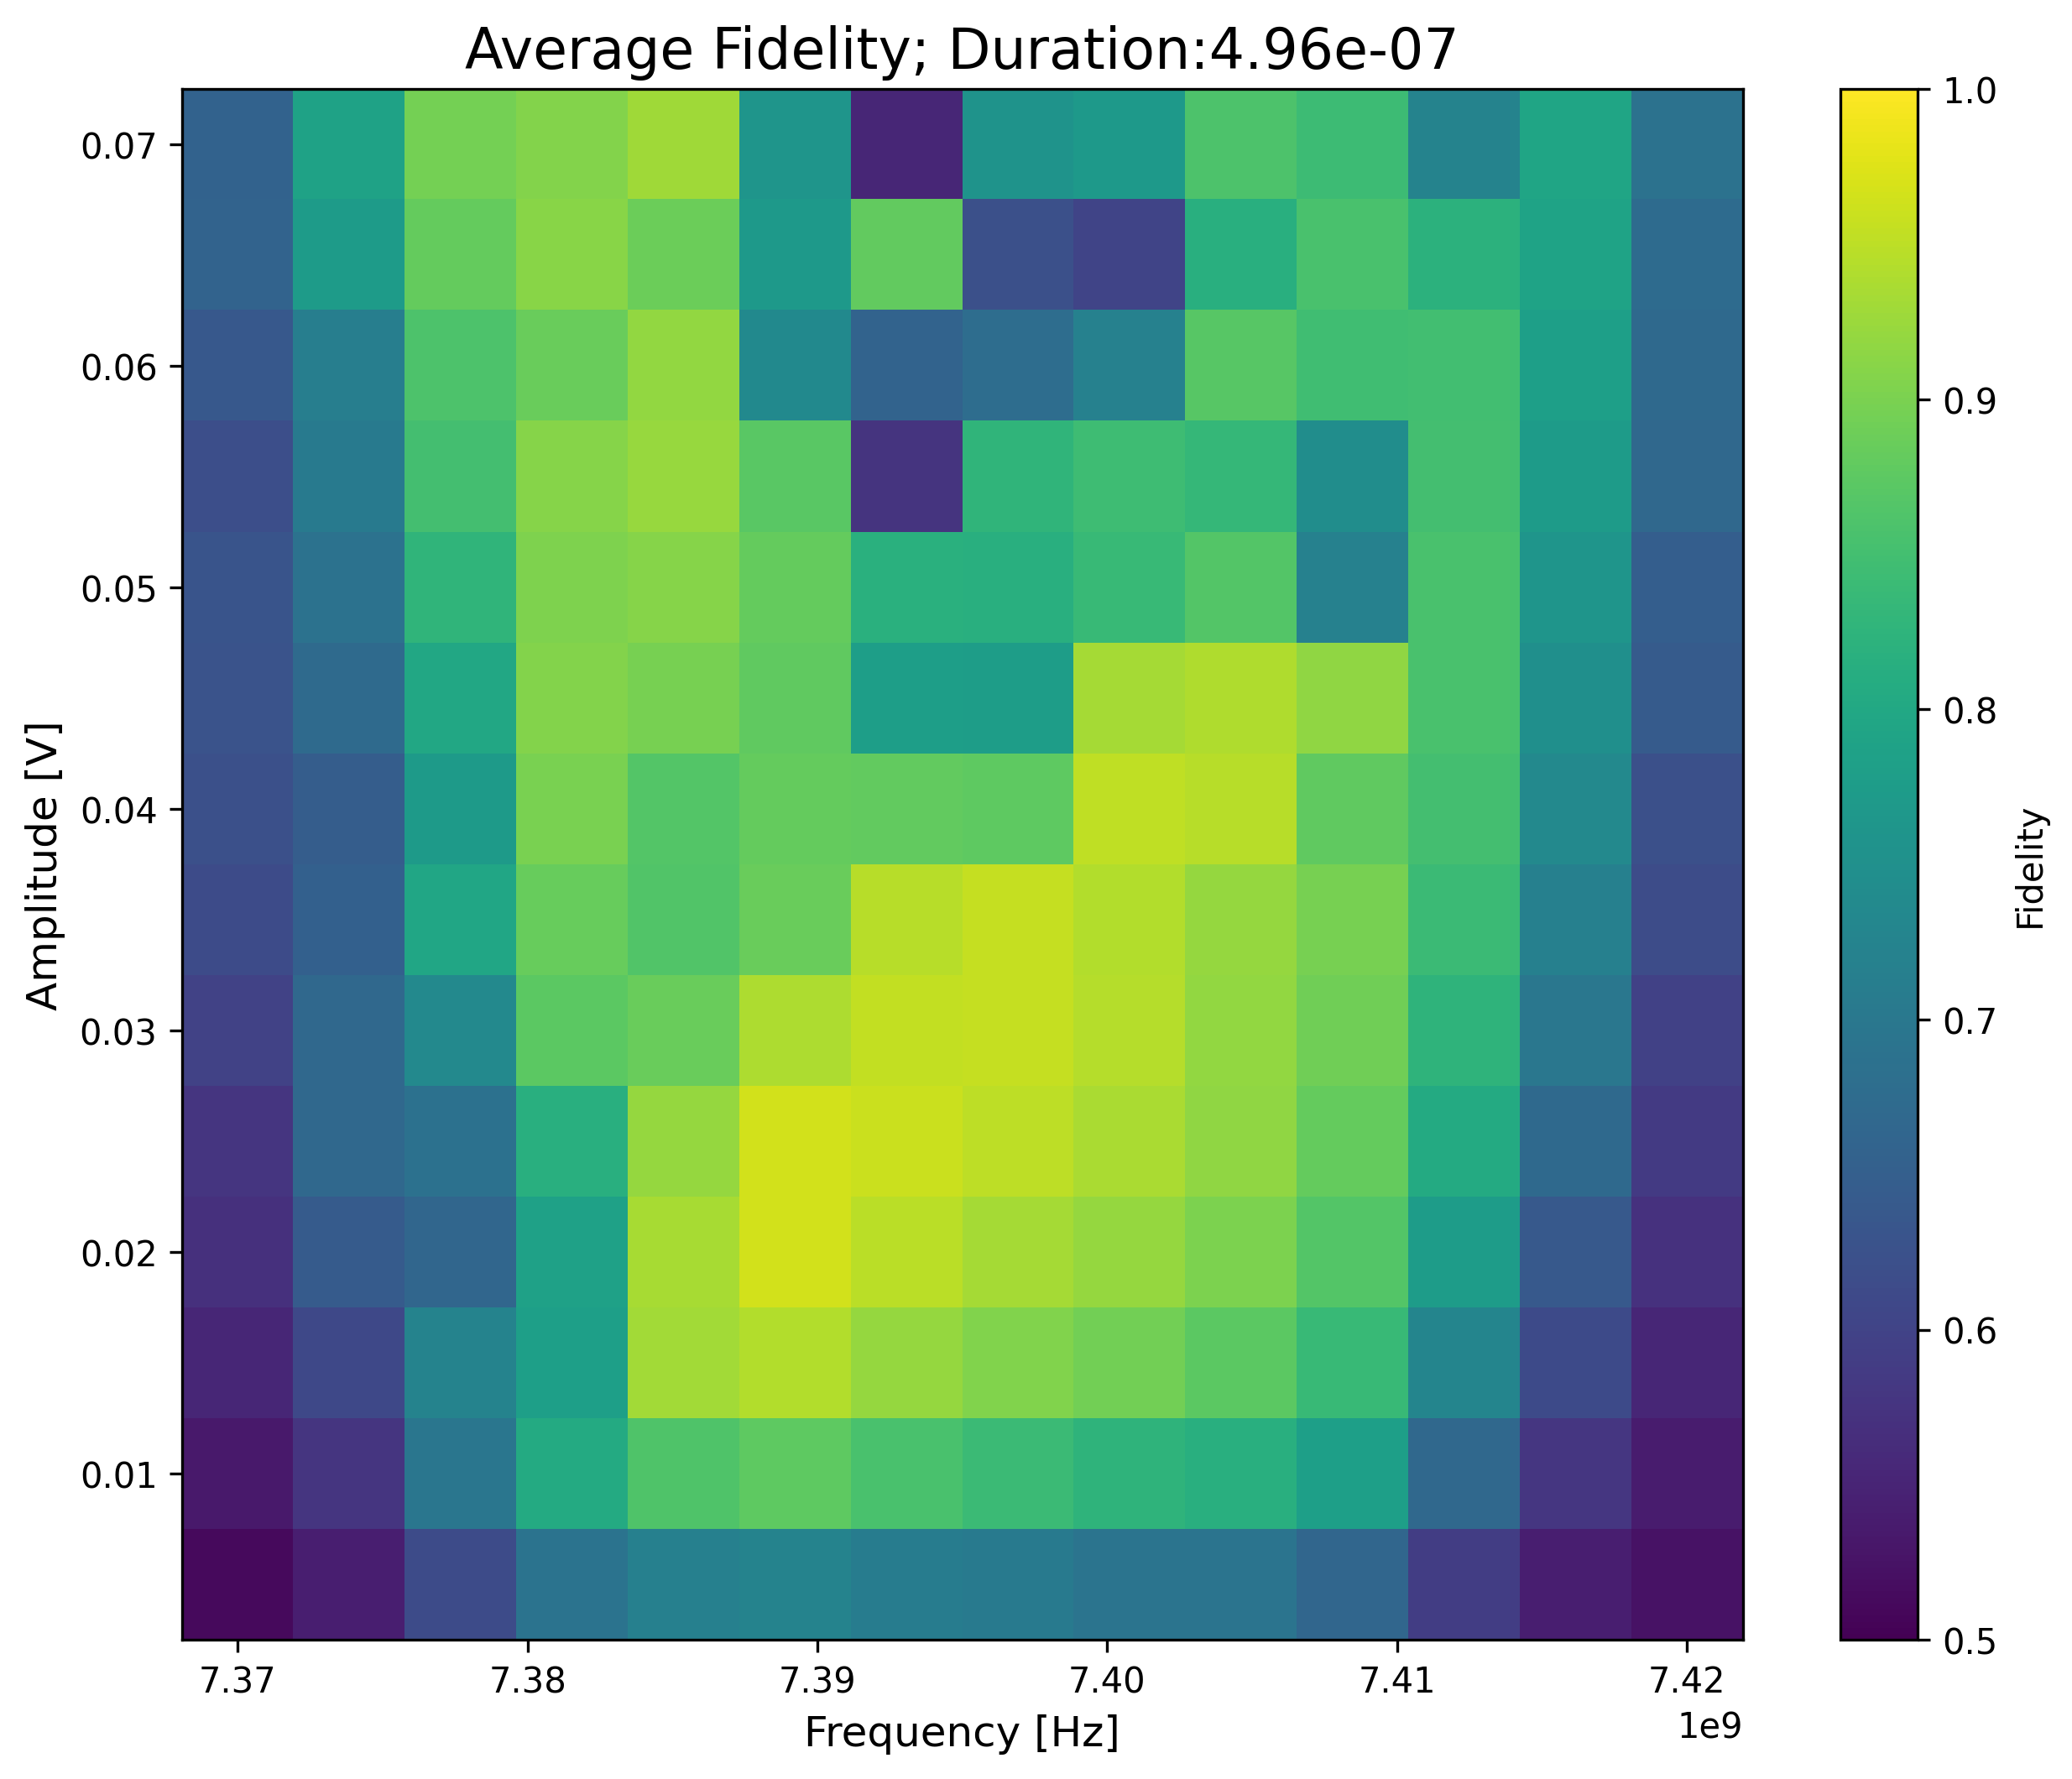

In [10]:
title = "Average Fidelity; Duration:" + str(unique_duration_values[-1])
print(title)
plotSingleFidelity(freq_reshape[-1], amplitude_reshape[-1], average_fidelity_reshape[-1], title)